In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read Files

In [2]:
csv_folder = 'C:/Users/Neil/OneDrive/Documents/Capstone Files/' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [3]:
csv_files

['C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M1-24.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M13-36.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M25-48.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M37-60.csv']

## Splitting

In [4]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M1-24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998525
1    0.001475
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998513
1    0.001487
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M13-36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.994214
1    0.005786
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.994182
1    0.005818
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M25-48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.986499
1    0.013501
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.98652
1    0.01348
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M37-60.csv
Train class balance:
 DEFAULT_TAGGING
0    0.974224


In [5]:
X_train_split_0, X_val, y_train_split_0, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split_0:", X_train_split_0.shape)
print("X_val:", X_val.shape)
print("y_train_split_0:", y_train_split_0.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split_0: (78197, 33)
X_val: (33514, 33)
y_train_split_0: (78197,)
y_val: (33514,)


In [6]:
Y1= pd.concat([X_train_split_0, y_train_split_0], axis=1)

In [7]:
Y1

,EverAtLeast1DPD_3mos,EverAtLeast15DPD_3mos,EverAtLeast31DPD_3mos,EverAtLeast61DPD_3mos,EverAtLeast1DPD_6mos,EverAtLeast15DPD_6mos,EverAtLeast31DPD_6mos,EverAtLeast61DPD_6mos,EverAtLeast1DPD_9mos,EverAtLeast15DPD_9mos,...,Missed_past6mos,Partial_past6mos,Full_past6mos,Missed_past9mos,Partial_past9mos,Full_past9mos,Missed_past12mos,Partial_past12mos,Full_past12mos,DEFAULT_TAGGING
11757,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
39534,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
9963,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
72838,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
40217,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,2,0,10,0
24028,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
36067,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,2,0,10,0
24985,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,3,0,9,0


In [8]:
# Define X1 (features) and y1 (target)
X_1 = Y1.drop(columns=["DEFAULT_TAGGING"])  
Y_1 = Y1["DEFAULT_TAGGING"].astype(int)  # Convert target to integer Series

In [9]:
from imblearn.over_sampling import SMOTENC
# import numpy as np
# import pandas as pd
from collections import Counter

# Define feature groups
binary_features = ['EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos',
                   'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos',
                   'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos',
                   'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos']

ordinal_features = ['WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos']

continuous_features = ['RemainingLoanRatio_12mos']

count_features = ['Missed_past3mos', 'Partial_past3mos', 'Full_past3mos',
                  'Missed_past6mos', 'Partial_past6mos', 'Full_past6mos',
                  'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos',
                  'Missed_past12mos', 'Partial_past12mos', 'Full_past12mos']

# Get categorical feature indices for SMOTE-NC  
categorical_feature_indices = [X_1.columns.get_loc(col) for col in binary_features + ordinal_features]

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.20)
X1_resampled, Y1_resampled = smote_nc.fit_resample(X_1, Y_1)

# Convert back to DataFrame
x1_resampled = pd.DataFrame(X1_resampled, columns=X_1.columns)
y1_resampled = pd.Series(Y1_resampled, name="DEFAULT_TAGGING")

# Post-processing: Round categorical & count features
x1_resampled[binary_features] = x1_resampled[binary_features].round().astype(int)
x1_resampled[ordinal_features] = x1_resampled[ordinal_features].round().astype(int)
x1_resampled[count_features] = x1_resampled[count_features].round().astype(int)

# Print class distribution
print("Before SMOTE:", Counter(Y_1))
print("After SMOTE:", Counter(y1_resampled))

Before SMOTE: Counter({0: 77699, 1: 498})
After SMOTE: Counter({0: 77699, 1: 15539})


In [10]:
Y1_resampled = pd.concat([x1_resampled, y1_resampled], axis=1)

# Check if rows are still aligned properly
print(Y1_resampled.tail())  # Preview first few rows

       EverAtLeast1DPD_3mos  EverAtLeast15DPD_3mos  EverAtLeast31DPD_3mos  \
93233                     0                      0                      0   
93234                     0                      0                      0   
93235                     1                      1                      1   
93236                     0                      0                      0   
93237                     0                      0                      0   

       EverAtLeast61DPD_3mos  EverAtLeast1DPD_6mos  EverAtLeast15DPD_6mos  \
93233                      0                     0                      0   
93234                      0                     0                      0   
93235                      1                     1                      1   
93236                      0                     0                      0   
93237                      0                     0                      0   

       EverAtLeast31DPD_6mos  EverAtLeast61DPD_6mos  EverAtLeast1DPD_9mos 

In [11]:
xvars = [
    'EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos', 'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 'Partial_past3mos', 'Full_past3mos', 'Missed_past6mos', 'Partial_past6mos', 
    'Full_past6mos', 'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 'Full_past12mos'
]
    
yvar = 'DEFAULT_TAGGING'  # Target variable for y1

# Prepare training data (y1)
X_train_split = Y1_resampled[xvars]
y_train_split = Y1_resampled[yvar]

#### Option 1 Grid Search 

In [21]:
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
import lightgbm as lgb
import numpy as np
from itertools import product

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity


#change param_grid based on your chosen range of values
def grid_search_lgbm(X_train_split, y_train_split, X_val, y_val):
    param_grid = {
        'num_leaves': np.linspace(20, 100, 5, dtype=int),
        'learning_rate': np.linspace(0.03, 0.15, 5),
        'num_iterations': np.linspace(50, 200, 4, dtype=int)
    }






    best_results = {
        'recall': {'score': -np.inf, 'params': None},
        'specificity': {'score': -np.inf, 'params': None}
    }

    print("Starting Grid Search for num_leaves, learning_rate, and num_iterations...\n")

    for num_leaves, learning_rate, num_iterations in product(
        param_grid['num_leaves'], param_grid['learning_rate'], param_grid['num_iterations']
    ):
        model = lgb.LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            metric='binary_logloss',
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            num_leaves=num_leaves,
            is_unbalanced=True,
            random_state=42,
            bagging_seed=42,
            feature_fraction_seed=42,
            drop_seed=42,
            data_random_seed=42,
            deterministic=True,
            n_jobs=1
        )

        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)

        # Threshold tuning based on maximum F1 score
        precision, recall_arr, thresholds = precision_recall_curve(y_val, y_proba[:, 1])
        f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
        optimal_threshold = thresholds[np.argmax(f1_scores)]

        # Apply optimal threshold
        y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

        recall = recall_score(y_val, y_pred)
        specificity = calculate_specificity(y_val, y_pred)

        print(f"Params: num_leaves={num_leaves}, learning_rate={learning_rate:.3f}, num_iterations={num_iterations}")
        print(f" → Optimal Threshold: {optimal_threshold:.4f}")
        print(f" → Recall: {recall:.4f}, Specificity: {specificity:.4f}\n")

        if recall > best_results['recall']['score']:
            best_results['recall'] = {
                'score': recall,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

        if specificity > best_results['specificity']['score']:
            best_results['specificity'] = {
                'score': specificity,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

    # Print final best results
    print("Grid Search Complete!\n")
    print("Best Recall Score:")
    print(f" → Score: {best_results['recall']['score']:.4f}")
    print(f" → Params: {best_results['recall']['params']}\n")

    print("Best Specificity Score:")
    print(f" → Score: {best_results['specificity']['score']:.4f}")
    print(f" → Params: {best_results['specificity']['params']}\n")

    return best_results

In [22]:
results = grid_search_lgbm(X_train_split, y_train_split, X_val, y_val)
print(results)

Starting Grid Search for num_leaves, learning_rate, and num_iterations...

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=20, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7614
 → Recall: 0.7418, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=20, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.8636
 → Recall: 0.7418, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=20, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9178
 → Recall: 0.7371, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.8473
 → Recall: 0.7653, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.8679
 → Recall: 0.7465, Specificity: 0.9996



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=20, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9100
 → Recall: 0.7418, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=20, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.8573
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=20, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9177
 → Recall: 0.7277, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.8921
 → Recall: 0.7465, Specificity: 0.9996



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9081
 → Recall: 0.7465, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=20, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.8880
 → Recall: 0.7418, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=20, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.8790
 → Recall: 0.7277, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=20, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.8476
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=20, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.8250
 → Recall: 0.7559, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=20, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9222
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 83
True Positives (TP): 130
Params: num_leaves=20, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9861
 → Recall: 0.6103, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9153
 → Recall: 0.7465, Specificity: 0.9997



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=20, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9087
 → Recall: 0.7324, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=20, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.8918
 → Recall: 0.7136, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=20, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.8840
 → Recall: 0.7042, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=40, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7708
 → Recall: 0.7559, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=40, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.8768
 → Recall: 0.7418, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=40, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.8734
 → Recall: 0.7559, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=40, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.8877
 → Recall: 0.7512, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=40, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.8542
 → Recall: 0.7465, Specificity: 0.9995



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=40, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.8748
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=40, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.8712
 → Recall: 0.7465, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=40, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9175
 → Recall: 0.7089, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33275
False Positives (FP): 26
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=40, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.8244
 → Recall: 0.7840, Specificity: 0.9992



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=40, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9180
 → Recall: 0.7324, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=40, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9411
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=40, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9413
 → Recall: 0.6948, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=40, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.8983
 → Recall: 0.7418, Specificity: 0.9996



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=40, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9365
 → Recall: 0.6995, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=40, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9247
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=40, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9193
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=40, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.8769
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Local\Temp\ipykernel_17260\1605550589.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 213
True Positives (TP): 0
Params: num_leaves=40, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 1.0000
 → Recall: 0.0000, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Local\Temp\ipykernel_17260\1605550589.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 213
True Positives (TP): 0
Params: num_leaves=40, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 1.0000
 → Recall: 0.0000, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=60, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7813
 → Recall: 0.7559, Specificity: 0.9995



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9430
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=60, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9317
 → Recall: 0.7230, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=60, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.8266
 → Recall: 0.7465, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9453
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=60, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.8847
 → Recall: 0.7371, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=60, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9366
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=60, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.8701
 → Recall: 0.7183, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=60, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9113
 → Recall: 0.7371, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=60, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.8728
 → Recall: 0.7183, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=60, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9239
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=60, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9183
 → Recall: 0.7089, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=60, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.8783
 → Recall: 0.7324, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33299
False Positives (FP): 2
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=60, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9659
 → Recall: 0.6761, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=60, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9555
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=60, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9744
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=60, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.8964
 → Recall: 0.7136, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=60, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9313
 → Recall: 0.6948, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=60, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9617
 → Recall: 0.6854, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=60, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9797
 → Recall: 0.6761, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33276
False Positives (FP): 25
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=80, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7131
 → Recall: 0.7793, Specificity: 0.9992



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=80, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9436
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=80, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9027
 → Recall: 0.7371, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=80, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.8826
 → Recall: 0.7371, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=80, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.8411
 → Recall: 0.7465, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=80, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.8698
 → Recall: 0.7371, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=80, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9249
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=80, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9392
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=80, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.8847
 → Recall: 0.7371, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=80, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9235
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=80, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9448
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33299
False Positives (FP): 2
False Negatives (FN): 72
True Positives (TP): 141
Params: num_leaves=80, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9862
 → Recall: 0.6620, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=80, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.8975
 → Recall: 0.7136, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=80, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9512
 → Recall: 0.6948, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=80, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9724
 → Recall: 0.6901, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=80, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9806
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=80, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9244
 → Recall: 0.7230, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=80, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9430
 → Recall: 0.6948, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 71
True Positives (TP): 142
Params: num_leaves=80, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9895
 → Recall: 0.6667, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 71
True Positives (TP): 142
Params: num_leaves=80, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9925
 → Recall: 0.6667, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=100, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7912
 → Recall: 0.7465, Specificity: 0.9995



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=100, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9470
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=100, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.8900
 → Recall: 0.7324, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=100, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.8771
 → Recall: 0.7277, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=100, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9480
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=100, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9241
 → Recall: 0.7089, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33299
False Positives (FP): 2
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9718
 → Recall: 0.6901, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9648
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=100, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9075
 → Recall: 0.7089, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9440
 → Recall: 0.6901, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 70
True Positives (TP): 143
Params: num_leaves=100, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9800
 → Recall: 0.6714, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=100, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9805
 → Recall: 0.6761, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=100, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9312
 → Recall: 0.6948, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=100, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9730
 → Recall: 0.6761, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=100, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9783
 → Recall: 0.6854, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=100, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9885
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=100, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9649
 → Recall: 0.6854, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=100, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9602
 → Recall: 0.6995, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=100, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9837
 → Recall: 0.6948, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=100, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9888
 → Recall: 0.7042, Specificity: 0.9997

Grid Search Complete!

Best Recall Score:
 → Score: 0.7840
 → Params: {'num_leaves': 40, 'learning_r

## LGBM MODEL

In [14]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.09,
    num_iterations=50,
    num_leaves=60,
    is_unbalanced=True,
    random_state=42,
    bagging_seed=42,
    feature_fraction_seed=42,
    drop_seed=42,
    data_random_seed=42,
    deterministic=True,
    n_jobs=1
)


#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 15539, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 93238, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166660 -> initscore=-1.609489
[LightGBM] [Info] Start training from score -1.609489
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Model Training Complete


## Option 1: Optimal Threshold using Precision-Recall Curve

In [15]:
# Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal threshold for maximum F1 score:", optimal_threshold)

Optimal threshold for maximum F1 score: 0.9113386182676182


## Apply Optimal Threshold

In [17]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 1]


## Metrics Evaluation

In [18]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 56
True Positives (TP): 157
[[33291    10]
 [   56   157]]
Accuracy: 0.9980
Precision: 0.9401
Recall: 0.7371
F1 Score: 0.8263
AUC: 0.9816
Specificity: 0.9997


## SHAP Plots

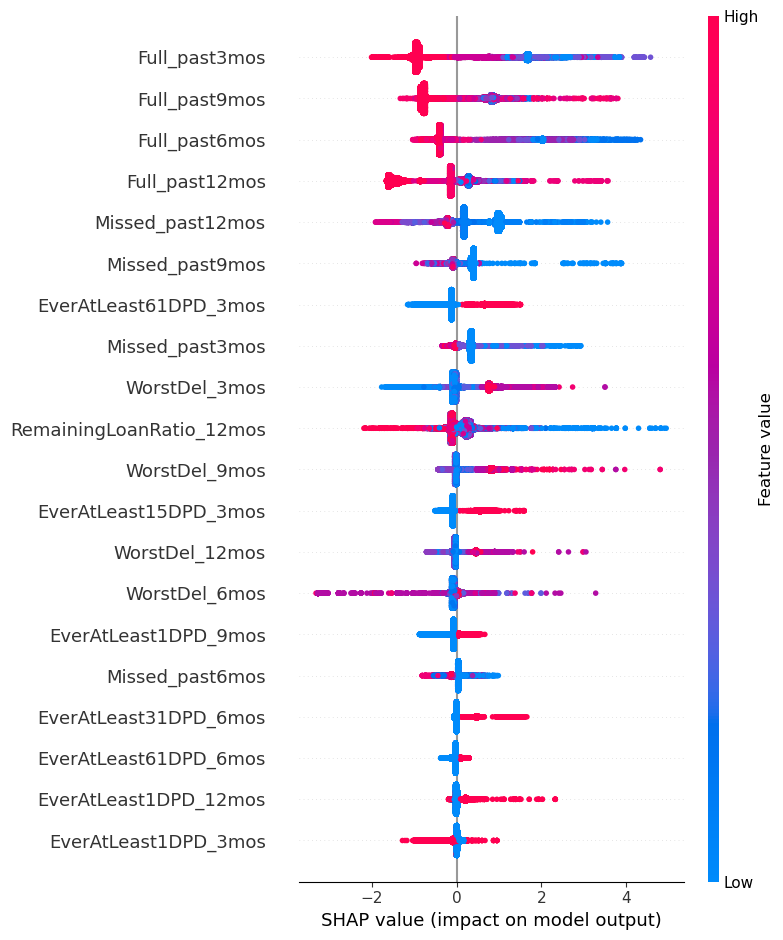

In [19]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

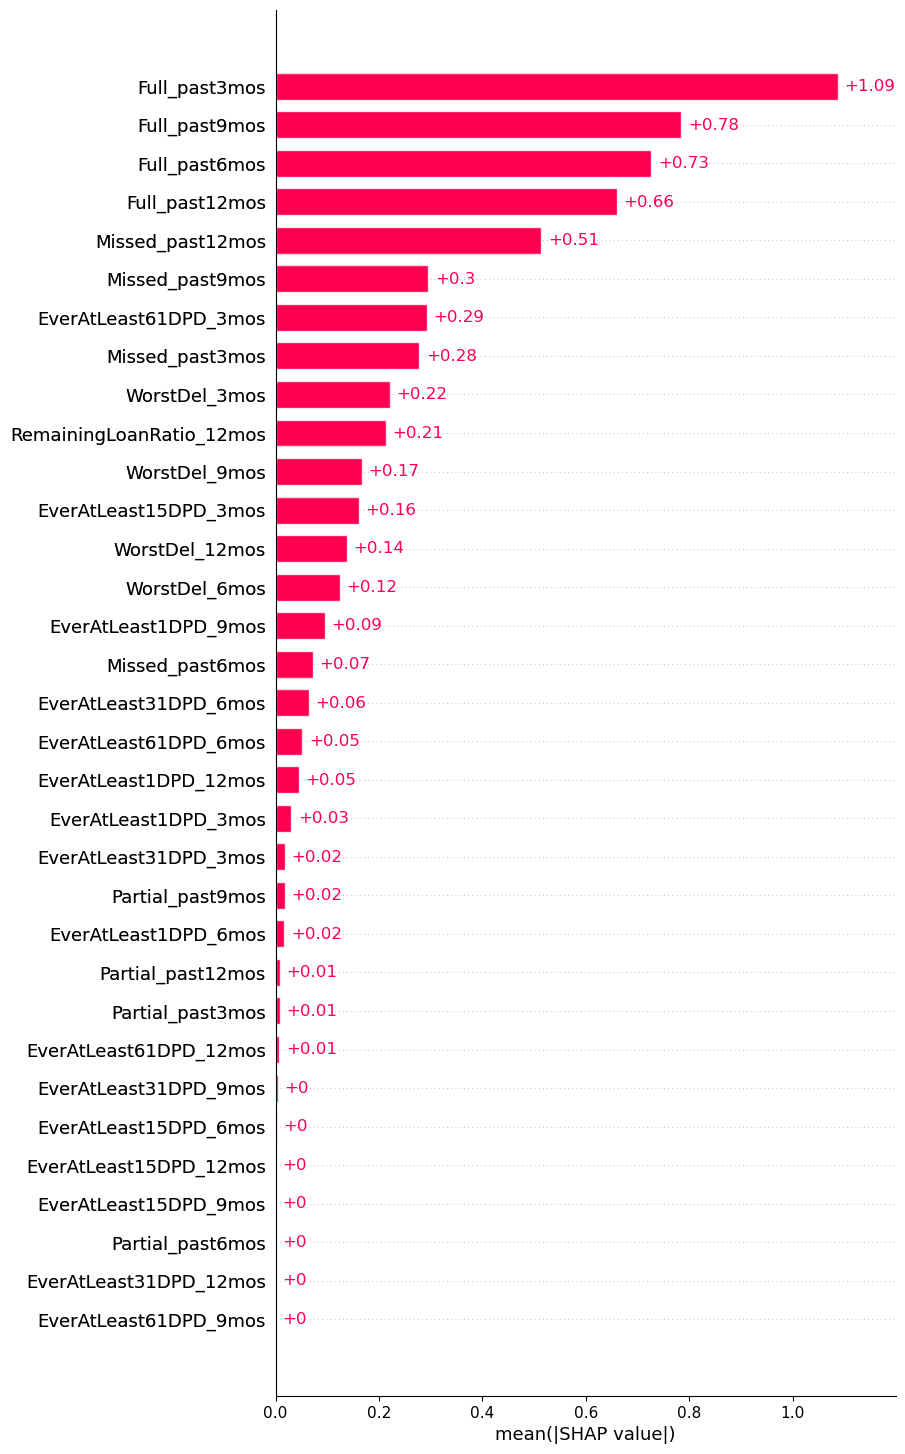

In [20]:
shap.plots.bar(shap_values, max_display=50)